In [1]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib qt

In [2]:
os.chdir("D:/222experiment_material/EEG_DATA")  # 修改当前工作目录
file_path = './practice/lkm_p_raw/pain_2.mff'

In [8]:
raw = mne.io.read_raw_egi(file_path)


Reading EGI MFF Header from D:\222experiment_material\EEG_DATA\practice\lkm_p_raw\pain_2.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {pain} ...


In [9]:

# 滤波
raw_filter = raw.copy()
raw_filter.load_data()
raw_filter.filter(l_freq=0.1, h_freq=30)
raw_filter.notch_filter(freqs=50)
plt.show(block=True)
raw_filter.plot(start=20, duration=1, block=True, title='无误请关闭窗口')


Reading 0 ... 514693  =      0.000 ...   514.693 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:    2.6s finished


Channels marked as bad:
none


KeyboardInterrupt: 

In [17]:
# 降采样
raw_filter.resample(sfreq=250)
sfreq = raw_filter.info['sfreq']
events = mne.find_events(raw_filter, stim_channel='STI 014')
oppa = mne.find_events(raw_filter, stim_channel='onpa')
onno = mne.find_events(raw_filter, stim_channel='onno')
if oppa[0, 2] < onno[0, 2]:
    events_id = {
        1 : 'stat',
        2 : 'onpa',
        3 : 'onno',
        4 : 'rest'
    }
else:
    events_id = {
        1 : 'stat',
        2 : 'onno',
        3 : 'onpa',
        4 : 'rest'
     }

anno = mne.annotations_from_events(events, sfreq, event_desc=events_id, first_samp=0, orig_time=None, verbose=None)
raw_filter.set_annotations(anno)

126 events found
Event IDs: [1 2 3 4]
126 events found
Event IDs: [1 2 3 4]
126 events found
Event IDs: [1 2 3 4]
60 events found
Event IDs: [4]
60 events found
Event IDs: [3]


<RawMff | signal1.bin, 135 x 128674 (514.7 s), ~132.7 MB, data loaded>

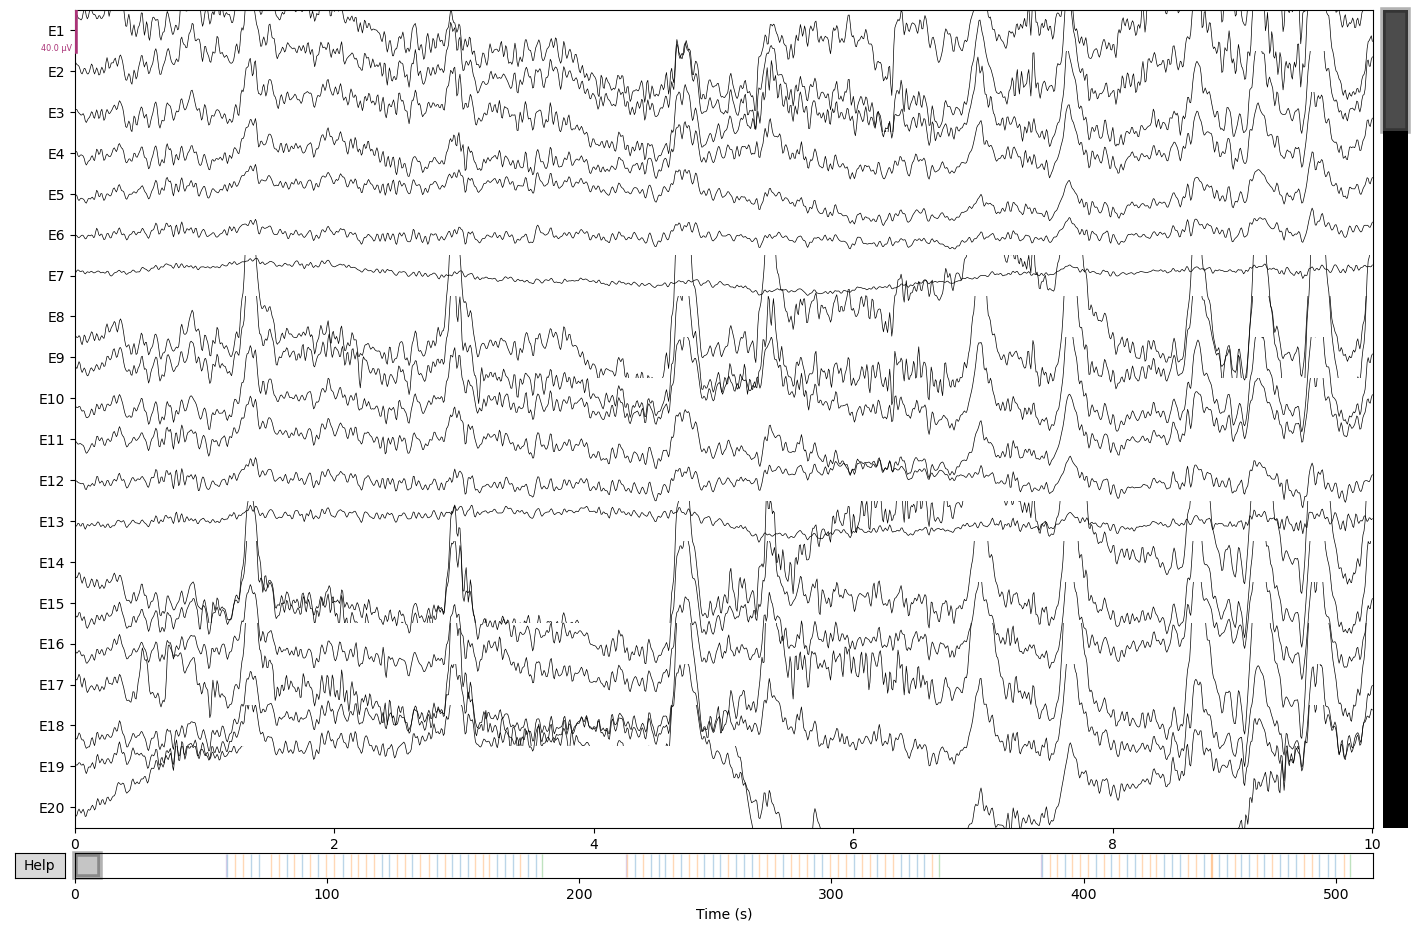

Channels marked as bad:
none


In [18]:
raw_filter.plot()

In [5]:
 # 查看坏导
raw_bad= raw_filter.copy()  # 备份原数据
raw_bad.plot(block=True,title = '请选出坏导')
# print(epoch_bad.info['bads'])



Channels marked as bad:
['E7', 'E8', 'E14', 'E20']


KeyboardInterrupt: 

In [ ]:
# 插值坏导
raw_bad.load_data()
raw_bad.interpolate_bads()
raw_bad.plot(block=True,title = '坏导插值完成')


Interpolating bad channels
    Automatic origin fit: head of radius 99.1 mm
Computing interpolation matrix from 125 sensor positions
Interpolating 4 sensors
Channels marked as bad:
['E7']


In [8]:
if raw_bad.info['bads']:
    print('yes')

In [ ]:
# 重参考
raw_reference = raw_bad.copy()
raw_reference.load_data()
raw_reference.set_eeg_reference(ref_channels=['E57', 'E100'])




In [10]:

# ICA之前对通道的修正
fig=raw_reference.plot(block=True, title='重参考完成，无误请关闭窗口')
fig.fake_keypress('a')  # 注释坏段

Channels marked as bad:
none


KeyboardInterrupt: 

In [15]:
# ICA
ica = mne.preprocessing.ICA(n_components=30, method='fastica', max_iter=800)
ica.fit(raw_reference,reject_by_annotation = True )
raw_reference.load_data()
# ica.plot_components()
# ica.plot_properties(raw, picks= [0,1,2,3,4,5,6,7,8,9])
ica.plot_sources(raw_reference, show_scrollbars=False, title='选择需要去除的成分')
plt.show(block=True)


Fitting ICA to data using 129 channels (please be patient, this may take a while)
Omitting 49247 of 470729 (10.46%) samples, retaining 421482 (89.54%) samples.
Selecting by number: 30 components
Fitting ICA took 40.6s.
Creating RawArray with float64 data, n_channels=30, n_times=470729
    Range : 0 ... 470728 =      0.000 ...   470.728 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
204 matching events found
No baseline correction applied
0 proje

KeyboardInterrupt: 

In [16]:

raw_ica = raw_reference.copy()
raw_ica = ica.apply(raw_ica)
raw_reference.plot(title='ICA处理前, 确认请关闭')
raw_ica.plot(title='ICA处理后, 确认请关闭')
plt.show(block=True)



Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 129 PCA components
Channels marked as bad:
none
Channels marked as bad:
none


KeyboardInterrupt: 

In [19]:
# 判断刺激标签
event = mne.find_events(raw_filter, stim_channel='STI 014')
oppa = mne.find_events(raw_filter, stim_channel='onpa')
onno = mne.find_events(raw_filter, stim_channel='onno')

if oppa[0, 2] < onno[0, 2]:
    events_id = {
         'stat': 1,
         'onpa': 2,
         'onno': 3,
         'rest': 4
    }
else:
    events_id = {
        'stat': 1,
        'onno': 2,
        'onpa': 3,
        'rest': 4
     }
    # mne.viz.plot_events(event)
events = [event, events_id]
event_dict = {'no_pain': events[1]['onno'], 'pain': events[1]['onpa']}
reject_criteria = dict(eeg=100e-6)  # 100 µV
epochs = mne.Epochs(raw_ica, events[0], event_id=event_dict, preload=True, tmax=1,
                        tmin=-0.2)  # 运行中基线校正自动进行了,先不拒绝100μv
epochs.plot(events=events[0], block=True, title='请挑出坏的Epochs')







126 events found
Event IDs: [1 2 3 4]
60 events found
Event IDs: [4]
60 events found
Event IDs: [3]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 1201 original time points ...
8 bad epochs dropped
Dropped 5 epochs: 1, 8, 15, 59, 66
The following epochs were marked as bad and are dropped:
[2, 10, 17, 65, 72]
Channels marked as bad:
none


KeyboardInterrupt: 

In [21]:
# 剔除最后的坏段
epoch_final = epochs.drop_bad(reject=reject_criteria)


    Rejecting  epoch based on EEG : ['E72']
    Rejecting  epoch based on EEG : ['E46']
    Rejecting  epoch based on EEG : ['E66']
    Rejecting  epoch based on EEG : ['E122']
    Rejecting  epoch based on EEG : ['E60']
    Rejecting  epoch based on EEG : ['E121']
6 bad epochs dropped
